# GST on Rigetti Backends with PyGSTi
The purpose of this notebook is to use the data collected from a GST experiment that has been read into the `rigetti_first_run` directory and perform GST on it. 

This code was mostly taken from the tutorial notebook [UnitaryFundDemoNotebook1.ipynb
](https://zenodo.org/record/5715199#.Yr_TOUjMLJF). 

In [2]:
#PyGSTi tools
import pygsti
from pygsti.modelpacks import smq1Q_XZ
from pygsti.data.dataset import DataSet

#Rigetti tools
from mitiq.pec import NoisyOperation, NoisyBasis, OperationRepresentation, execute_with_pec
from mitiq.pec.representations.optimal import find_optimal_representation

#Qiskit imports
from qiskit import QuantumCircuit
from qiskit.quantum_info import SuperOp, Kraus, Operator, PTM 
from qiskit.circuit.library import RZGate, SXGate
from qiskit import transpile
from qiskit.providers.aer.noise import NoiseModel, QuantumError
from qiskit import execute, Aer

#Helper libraries
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

#make numpy matrices easier to read
np.set_printoptions(precision=3, suppress=True)
plt.style.use("ggplot")

## Read data from experiment
This data was written by the `get_gst_data.ipynb` file.

In [3]:
data = pygsti.io.read_data_from_dir('experiment_data/rigetti_first_run')

## Run GST on the data

In [4]:
gst_protocol = pygsti.protocols.StandardGST('TP,CPTP,Target')
results = gst_protocol.run(data)

-- Std Practice:  Iter 1 of 3  (TP) --: 
  --- Iterative GST: [##################################################] 100.0%  550 circuits ---
  Iterative GST Total Time: 2.1s
-- Std Practice:  Iter 2 of 3  (CPTP) --: 
  --- Iterative GST: [##################################################] 100.0%  550 circuits ---
  Iterative GST Total Time: 16.3s
-- Std Practice:  Iter 3 of 3  (Target) --: 


## Constrain to TPCP and gauge-optimize
The estimates_final_model is an `ExplicitOpModel` type, which carries the preps, measurements, and operations as Pauli-transfer matrices. The documentation refers to this as the 'pauli-product' basis. The `forest_benchmarking` tools can be used to convert these into superoperators, which is the form mitiq uses to describe quantum channels.

## Re-run GST experiment with fixed Rz

In this subsection we impose that RZ  must be equal to the ideal operation.

This is procedure is adapted from page 3 of https://arxiv.org/abs/2002.12476.
The main difference is that, instead of starting from a default initial model, we take the model the we obtained in the previous section, we fix RZ, and we use it as the initial condition for a new GST estimation.

(Literally applying procedure of page 3 of https://arxiv.org/abs/2002.12476 produce a final result but doesn't seem to make sense since all operators look like ideal gates).

In [6]:
# Define ideal RZ operation
target_mdl = smq1Q_XZ.target_model()
rz_matrix = target_mdl[('Gzpi2',0)].to_dense()
dense_rz = pygsti.modelmembers.operations.DenseOperator(rz_matrix, evotype="default")

In [7]:
cptp_estimate = results.estimates['CPTP']
initial_model = cptp_estimate.models['stdgaugeopt']
initial_model[('Gzpi2',0)] = dense_rz

In [8]:
# Run GST (on existing data)
results = pygsti.protocols.GST(initial_model, gaugeopt_suite=None).run(data)

--- Iterative GST: Iter 1 of 6  52 circuits ---: 
  MatrixLayout: 1 processors divided into 1 x 1 (= 1) grid along circuit and parameter directions.
     1 atoms, parameter block size limits (None,)
  *** Distributing 1 atoms to 1 atom-processing groups (1 cores) ***
      More atom-processors than hosts: each host gets ~1 atom-processors
      Atom-processors already occupy a single node, dividing atom-processor into 1 param-processors.
  *** Divided 1-host atom-processor (~1 procs) into 1 param-processing groups ***
  --- chi2 GST ---
  Sum of Chi^2 = 106.368 (52 data params - 36 (approx) model params = expected mean of 16; p-value = 2.22045e-15)
  Completed in 2.3s
  Iteration 1 took 2.3s
  
--- Iterative GST: Iter 2 of 6  96 circuits ---: 
  MatrixLayout: 1 processors divided into 1 x 1 (= 1) grid along circuit and parameter directions.
     1 atoms, parameter block size limits (None,)
  *** Distributing 1 atoms to 1 atom-processing groups (1 cores) ***
      More atom-processors t

In [9]:
new_model = results.estimates['GateSetTomography'].models['final iteration estimate']
print(new_model.operations[('Gxpi2',0)].to_dense())
print(new_model.operations[('Gzpi2',0)].to_dense())

[[ 1.    -0.     0.     0.   ]
 [ 0.007  0.989  0.06  -0.066]
 [-0.004 -0.058  0.012 -0.976]
 [-0.006 -0.057  0.975  0.015]]
[[ 1.  0.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  1.]]


In [14]:
# Convert operator transfer matrix to superoperator
superop_rep_x = SuperOp(PTM(new_model.operations[('Gxpi2',0)].to_dense()))
superop_rep_z = SuperOp(PTM(new_model.operations[('Gzpi2',0)].to_dense()))
superops = [superop_rep_x, superop_rep_z]

In [26]:
#Create a list of ideal gates as labels for the noisy ones
ideal_gates = [SXGate(), RZGate(np.pi/2), IGate()]

In [27]:
def get_gate_sequences(n):
    NoisyOperations = []

    for string in product(zip(superops,ideal_gates), repeat=n): #combine the noisy and ideal ops and iterate through words
        qc = QuantumCircuit(1)
        superop = SuperOp(np.identity(4)) #start at the identity op

        for (noisy_op, ideal_op) in string: #iterate through all the pairs in string
            qc.append(ideal_op,[0]) #add the ideal op to circuit
            superop = superop.compose(noisy_op) #compose the noisy op for total channel

        NoisyOperations.append(NoisyOperation(qc, superop.data)) #Instatiate NoisyOperation and add to array
    
    return NoisyOperations.copy()

NoisyOperations = []
N = 4

for i in range(N): #do this for all n <= N
    NoisyOperations = np.concatenate((NoisyOperations, get_gate_sequences(i+1)))

#combine into basis object
noisy_basis = NoisyBasis(*NoisyOperations)

In [28]:
noisy_basis = NoisyBasis(*NoisyOperations)

In [29]:
optimal_circuit = QuantumCircuit(1)
optimal_circuit.append(RXGate(-np.pi/2), [0])

#get optimal representation in terms of noisy gates
optimal_rep = find_optimal_representation(optimal_circuit, noisy_basis, tol=.0001)

optimal_circuit = QuantumCircuit(1)
optimal_circuit.sx(0)
optimal_rep = OperationRepresentation(optimal_circuit,optimal_rep.basis_expansion)

print(optimal_rep)
print("Overhead: ", optimal_rep.norm) #hopefully close to 1

q_0: ───X^0.5─── = -0.112*(q_0: ───X^0.5───X^0.5───X^0.5───X^0.5───)+0.277*(q_0: ───Rz(0.5π)───X^0.5───X^0.5───Rz(0.5π)───)+0.024*(q_0: ───Rz(0.5π)───X^0.5───Rz(0.5π)───X^0.5───)+0.389*(q_0: ───X^0.5───X^0.5───Rz(0.5π)───X^0.5───)+0.717*(q_0: ───X^0.5───)-0.314*(q_0: ───X^0.5───X^0.5───X^0.5───)+0.010*(q_0: ───X^0.5───Rz(0.5π)───Rz(0.5π)───Rz(0.5π)───)+0.364*(q_0: ───Rz(0.5π)───Rz(0.5π)───Rz(0.5π)───Rz(0.5π)───)-0.008*(q_0: ───Rz(0.5π)───Rz(0.5π)───Rz(0.5π)───X^0.5───)-0.372*(q_0: ───Rz(0.5π)───X^0.5───Rz(0.5π)───Rz(0.5π)───)+0.005*(q_0: ───Rz(0.5π)───X^0.5───X^0.5───)+0.048*(q_0: ───Rz(0.5π)───)-0.030*(q_0: ───Rz(0.5π)───Rz(0.5π)───X^0.5───)
Overhead:  2.6700759004107626


In [30]:
matrices = [m.channel_matrix for m in optimal_rep.noisy_operations]
mat = sum(m*coeff for (m,coeff) in zip(matrices, optimal_rep.coeffs))
print("Approximated superoperator")
print(mat)
print('------------------------------')
print("Ideal superoperator")
ideal_mat = SuperOp(RXGate(np.pi/2)).data #It clearly matches RX(pi/2), but I don't know why
print(ideal_mat)

Approximated superoperator
[[ 0.5-0.j   0. -0.5j  0. +0.5j  0.5+0.j ]
 [ 0. -0.5j  0.5-0.j   0.5+0.j   0. +0.5j]
 [ 0. +0.5j  0.5-0.j   0.5+0.j   0. -0.5j]
 [ 0.5+0.j  -0. +0.5j -0. -0.5j  0.5-0.j ]]
------------------------------
Ideal superoperator
[[0.5+0.j  0. -0.5j 0. +0.5j 0.5+0.j ]
 [0. -0.5j 0.5+0.j  0.5+0.j  0. +0.5j]
 [0. +0.5j 0.5+0.j  0.5+0.j  0. -0.5j]
 [0.5+0.j  0. +0.5j 0. -0.5j 0.5+0.j ]]


In [31]:
#convert PEC rep to PER rep
def get_canonical_noise_scaled_rep(op_rep : OperationRepresentation,
                                   lmbda) -> OperationRepresentation:
    #copy data from previous rep
    noisy_ops = op_rep.noisy_operations
    coeffs = list(op_rep.coeffs)
    ideal_program = op_rep.ideal

    #define terms
    gammaminus = .5*(op_rep.norm-1)
    gammaplus = .5*(op_rep.norm+1)

    #scale coefficients accordingly
    for (i,coeff) in enumerate(coeffs):
        if coeff < 0:
            coeffs[i] = coeff*(1-lmbda)
        else:
            coeffs[i] = coeff/gammaplus*(gammaplus-lmbda*gammaminus)
    
    #construct and return new representation
    scaled_rep_dict = dict(zip(noisy_ops, coeffs))
    return OperationRepresentation(ideal_program, scaled_rep_dict)

In [32]:
qc = QuantumCircuit(1)
qc.x(0)

qc = transpile(qc, basis_gates = ['rz','sx'])
qc.draw()

┌────┐┌────┐
q: ┤ √X ├┤ √X ├
   └────┘└────┘

In [43]:
rxnoise = superop_rep_x @ SuperOp(np.linalg.inv(SuperOp(SXGate()).data))

In [46]:
superop_rep_x

SuperOp([[ 0.505+0.j   , -0.029-0.487j, -0.029+0.487j,  0.489+0.j   ],
         [-0.03 -0.49j ,  0.5  -0.059j,  0.489+0.001j,  0.036+0.486j],
         [-0.03 +0.49j ,  0.489-0.001j,  0.5  +0.059j,  0.036-0.486j],
         [ 0.495+0.j   ,  0.029+0.487j,  0.029-0.487j,  0.511+0.j   ]],
        input_dims=(2,), output_dims=(2,))

In [47]:
rxnoise @ SuperOp(SXGate())

SuperOp([[ 0.505+0.j   , -0.029-0.487j, -0.029+0.487j,  0.489+0.j   ],
         [-0.03 -0.49j ,  0.5  -0.059j,  0.489+0.001j,  0.036+0.486j],
         [-0.03 +0.49j ,  0.489-0.001j,  0.5  +0.059j,  0.036-0.486j],
         [ 0.495+0.j   ,  0.029+0.487j,  0.029-0.487j,  0.511+0.j   ]],
        input_dims=(2,), output_dims=(2,))

In [49]:
noisemodel = NoiseModel()
rxerror = QuantumError(rxnoise)
noisemodel.add_all_qubit_quantum_error(rxerror, instructions=['sx'])

In [71]:
shots = 1000
def noisy_executor(circ):
    qc = circ.copy()
    backend = Aer.get_backend('qasm_simulator')
    qc.measure_all()
    counts = backend.run(qc, noise_model = noisemodel, shots=shots).result().get_counts()
    return (counts.get('0', 0)-counts.get('1',0))/shots

In [72]:
execute_with_pec(qc, noisy_executor, representations=[optimal_rep], num_samples= 5000)

-0.9449124228672575

In [67]:
noisy_executor(qc)

-0.964

In [208]:
deltat = .5
omega = .1
def trotter(T):
    qc = QuantumCircuit(1)
    N = int(T/deltat)
    for n in range(N):
        qc.rz(2*deltat*np.cos(n*deltat*omega), 0)
        qc.rx(2*deltat*np.sin(n*deltat*omega), 0)
    return qc

In [211]:
res = []
depths = np.linspace(0, 10*np.pi, 30)
for i in depths:
    qc = trotter(i)
    qc.measure_all()
    circ = transpile(qc,basis_gates = ['sx','rz'])
    results  = backend.run(qc, shots = 1000).result().get_counts()
    res.append((results.get('0',0)-results.get('1',0))/sum(results.values()))

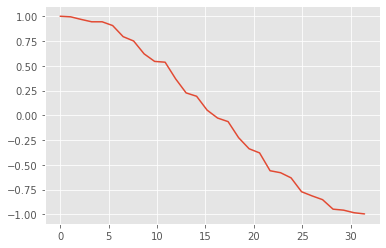

In [212]:
plt.plot(depths, res)